# [Physics 411](http://jklymak.github.io/Phy411/) Final Project
*John Coffey*


In [1]:
import matplotlib.pyplot as plt
from matplotlib import mlab, rcParams, dates
%matplotlib inline
import numpy as np
from scipy import interpolate, spatial, stats
import datetime
import scipy.signal as signal
import pandas as pd

#Load in all the data

In [2]:
# Minute data, 4 Schools
mins, dc = np.loadtxt('/Users/John/Documents/Project/DeepCoveNew.txt', unpack=True)
jb = np.loadtxt('/Users/John/Documents/Project/JamesBayNew.txt', usecols=([1]), unpack=True)
jm = np.loadtxt('/Users/John/Documents/Project/JohnMuirNew.txt', usecols=([1]), unpack=True)
uv = np.loadtxt('/Users/John/Documents/Project/UVicISCNew.txt', usecols=([1]), unpack=True)

In [3]:
# Coast data, 
coastfile = '/Users/John/Documents/Project/Coast.txt'  # longitudes followed by latitudes
coasts = np.loadtxt(coastfile)
cstlng = coasts[:len(coasts)/2]
cstlat = coasts[len(coasts)/2:]
# Hour data, Longtitude and Latitude, 35 Stations
hourfile = '/Users/John/Documents/Project/AllHourly.txt'
hourdata = np.loadtxt(hourfile)
data = hourdata[:,2:]
lng = hourdata[:,:1][:,0] - 360.  # -360 to fix that stations (0 to 360), coast (-180, 180).
lat = hourdata[:,1:2][:,0]

In [4]:
# Make hour data
# The data sets start on 1 Jan 2009 a minute after midnight local, or at 08:00 UTC = 733408.333.
d = datetime.date(2012,1,1)
tstart = 733408.333
hours = np.arange(tstart, tstart+len(data[0])/24., 1./24.)  # step size is every hour
d.fromordinal(int(hours[0])), d.fromordinal(int(hours[-1]))  # three years worth of data

# First three measurements for all stations are nan, remove
data = data[:,3:]
hours = hours[3:]

#Hourly 2D Plotting

C:\Users\John\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\John\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


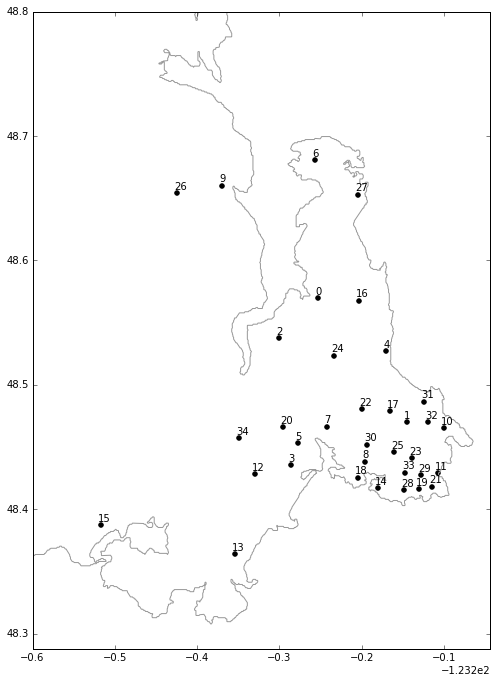

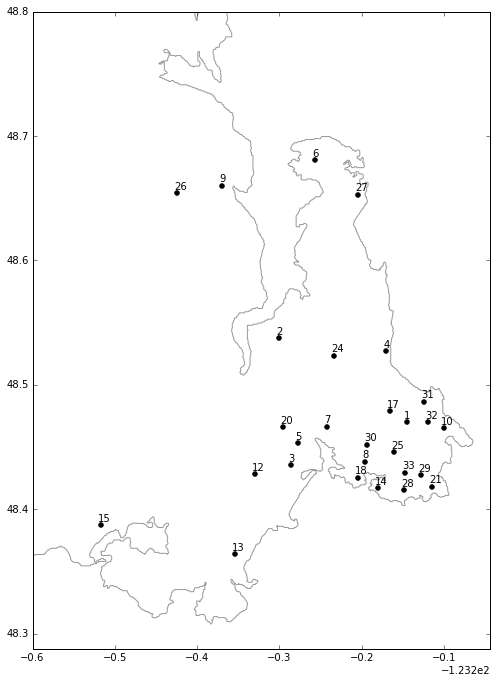

In [5]:
def station(cstlng, cstlat, lng, lat, nums = None, good = None):
    fig, ax = plt.subplots(1,1, figsize=(7,10))
    ax.plot(cstlng, cstlat, '-', color='0.6')
    
    if good is not None:
        ax.scatter(lng[good],lat[good], color='k')
    else:
        ax.scatter(lng,lat, color='k')
        
    ax.set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
    ax.set_ylim(np.min(cstlat)-0.02, 48.8)
    ax.set_aspect(1/np.cos(48.6*np.pi/180.))
    plt.tight_layout()
    
    labels = ['{0}'.format(i) for i in range(len(lng))]
    if nums is not None:
        for i in range(len(nums)):
            del labels[nums[-1-i]] 

    if good is not None:
        lng = lng[good]
        lat = lat[good]
        
    for label, x, y in zip(labels, lng, lat):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (-2, 2),
            textcoords = 'offset points', ha = 'left', va = 'bottom')#,
#            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))#,
#            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    #return fig

good = range(1,11)+range(12,16)+range(17,19)+range(20,22)+range(24,34)
bad = [0,11,16,19,22,23,34]
station(cstlng, cstlat, lng, lat)
plt.show()
station(cstlng, cstlat, lng, lat, bad, good)
plt.show()

In [6]:
def removeStations(data,lng,lat,good):
    data = data[good,:]
    lng =lng[good]
    lat = lat[good]
    return data,lng,lat

def interp(data):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    return data

def interp_nn(data, coords, tree, radius, rmean=False):
    
    # Nearest neighbour search for interpolation
    # replace value with average of neighbours
    # MAKE SURE TO ADJUST WEIGHTING TO NEAREST NEIGHBOURS **********
    # ^^^ never did but good enough

    for i in range(data.shape[0]):  # iterate through stations      
        idxs = tree.query_ball_point(coords[i], radius)
        if len(idxs) < 1:
            print 'STOP'
        nearby = data[idxs]
        nans = np.where(np.isnan(data[i]))
        for j in nans[0]:
            data[i,j] = np.nanmean(nearby[:,j])
        nans = np.where(np.isnan(data[i]))
        if len(nans) > 0:
            data[i,:] = interp(data[i,:])
        if rmean:
            data[i,:] -= np.mean(data[i,:])
    return data



In [7]:
print 35*26277
print data[:,26000].size
print data[0,:].size
print data[:,0][1]
print data[:,1][1]
print data[:,2][1]
print data[1,0:,]
print lng[0],lat[0]

919695
35
26277
nan
nan
nan
[     nan      nan      nan ...,  7.21183  7.21183  7.21183]
-123.453 48.5697


In [8]:
tree = spatial.KDTree(zip(lng.ravel(), lat.ravel()))
radius = 0.05  # in degrees
coords = np.dstack([lng, lat])[0]

data1 = interp_nn(data, coords, tree, radius, rmean=False)

data2,lng2,lat2 = removeStations(data,lng,lat,good)

tree2 = spatial.KDTree(zip(lng2.ravel(), lat2.ravel()))
radius2 = 0.05  # in degrees
coords2 = np.dstack([lng2, lat2])[0]

data3 = interp_nn(data2, coords2, tree2, radius2, rmean=False)

C:\Users\John\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [9]:
mask = np.loadtxt('coastline_mask.txt')  # array of 1's and nan's. switch values.
mask[np.isnan(mask)] = 0.              
mask[np.where(mask > 0.)] = np.nan
mask[~np.isnan(mask)] = 1. 

In [10]:
xi = np.linspace(-123.2, -123.8, 1000)
yi = np.linspace(48.3, 48.7, 1000)
gridx, gridy = np.meshgrid(xi, yi)

z = data1[:,1]  # one measurement for all stations

zl = mlab.griddata(lng, lat, z, xi, yi, interp='linear')
zc = interpolate.griddata(np.vstack((lng,lat)).T, z, (gridx,gridy), method='cubic')

z1 = data3[:,1]

zl2 = mlab.griddata(lng2, lat2, z1, xi, yi, interp='linear')
zc2 = interpolate.griddata(np.vstack((lng2,lat2)).T, z1, (gridx,gridy), method='cubic')


C:\Users\John\Anaconda\lib\site-packages\matplotlib\tri\triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


In [196]:
def plot2D(lng, lat, cstlng, cstlat, gridx, gridy, temp, mask=None):
    fig, axs = plt.subplots(1,1, figsize=(6,3))
    axs.plot(cstlng, cstlat, '-', color='k')
    if mask is not None:
        gridx = gridx*mask
        gridy = gridy*mask
    pcm = plt.pcolormesh(gridx, gridy, np.ma.masked_invalid(temp), cmap='coolwarm')
    axs.scatter(lng, lat, marker='+', color='k')
    axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'Latitude [deg]')
    axs.set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
    axs.set_ylim(np.min(cstlat)-0.02, 48.75)
    axs.set_aspect(1/np.cos(48.6*np.pi/180.))
    plt.colorbar(label=r'Temperature [$^\circ$C]')
    plt.tight_layout()
    return fig

In [238]:
def plot4(time, title, lng, lat, cstlng, cstlat, gridx, gridy, data, mask=None):
    fig, axs = plt.subplots(1,4,figsize=(16,6))#, sharey =True)

    m = 0
    for i in range(4):
        #for j in range(2):
        ztt = data[:,time[i]]
        zn = interpolate.griddata(np.vstack((lng,lat)).T, ztt, (gridx,gridy), method='cubic')
        axs[i].plot(cstlng, cstlat, '-', color='k')
        if mask is not None:
            gridx = gridx*mask
            gridy = gridy*mask
        pcm = axs[i].pcolormesh(gridx, gridy, np.ma.masked_invalid(zn), cmap='coolwarm')
        axs[i].scatter(lng, lat, marker='+', color='k')
            #axs[i,j].set_xlabel(r'Longitude [deg]') 
            #axs[i,j].set_ylabel(r'Latitude [deg]')
        axs[i].set_title(title[i])
        axs[i].set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
        axs[i].set_ylim(np.min(cstlat)-0.02, 48.75)
        axs[i].set_aspect(1/np.cos(48.6*np.pi/180.))
        plt.colorbar(pcm,ax=axs[i],shrink=0.5)
        plt.tight_layout()
            #m = m+1
    fig.subplots_adjust(hspace=0.11)
    #fig.subplots_adjust(wspace=0)
    #fig.tight_layout()
    #fig.tight_layout(rect=(0.15,0,1,1))
    fig.text(0.5, 0.1, r'Longitude [degrees]', ha='center',fontsize=12)
    fig.text(-0.01, 0.5, r'Latitude [degrees]', va='center', rotation='vertical',fontsize=12)
    #plt.setp([a.get_xticklabels() for a in fig.axes[0:]], visible=False)
    plt.suptitle('Annual Temperatures on Lower Vancouver Island',fontsize=17)
    plt.tight_layout()
    #plt.figure(figsize=(100*3.13,4*3.13))
    #fig.savefig('Annual.png', bbox_inches='tight')
    #plt.show()

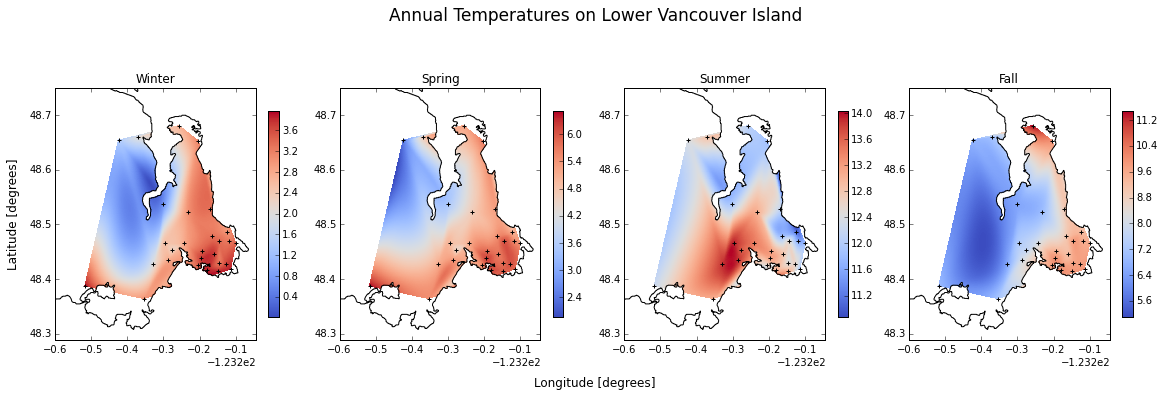

In [239]:
timme = [12,2200,4180,6500]
title = ['Winter','Spring','Summer','Fall']
    
plot4(timme, title, lng2,lat2,cstlng,cstlat,gridx,gridy,data3,mask)
#fig.savefig('Annual.png', bbox_inches='tight')
plt.show()

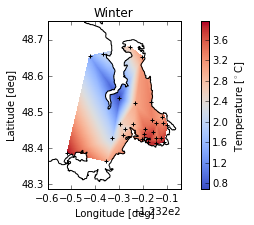

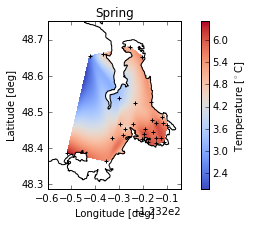

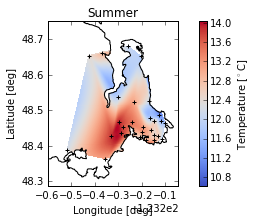

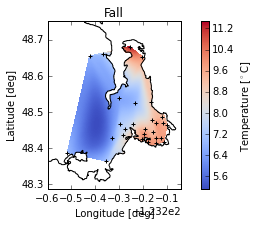

In [197]:
ztt = data3[:,12]
#Winter
zn = mlab.griddata(lng2, lat2, ztt, xi, yi, interp='linear')
znc = interpolate.griddata(np.vstack((lng2,lat2)).T, ztt, (gridx,gridy), method='cubic')

plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, zn, mask)
plt.title('Winter')
plt.show()

ztt = data3[:,2200]
#Spring
zn = mlab.griddata(lng2, lat2, ztt, xi, yi, interp='linear')
znc = interpolate.griddata(np.vstack((lng2,lat2)).T, ztt, (gridx,gridy), method='cubic')

plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, znc, mask)
plt.title('Spring')
plt.show()

ztt = data3[:,4180]
#Summer
zn = mlab.griddata(lng2, lat2, ztt, xi, yi, interp='linear')
znc = interpolate.griddata(np.vstack((lng2,lat2)).T, ztt, (gridx,gridy), method='cubic')

plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, znc, mask)
plt.title('Summer')
plt.show()

ztt = data3[:,6500]
#Fall
zn = mlab.griddata(lng2, lat2, ztt, xi, yi, interp='linear')
znc = interpolate.griddata(np.vstack((lng2,lat2)).T, ztt, (gridx,gridy), method='cubic')

plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, znc, mask)
plt.title('Fall')
plt.show()


In [288]:
N = len(data3[0])
print N,data3[:,0].size
print data3[:,0]
np.sum(data3[:,0])

26277 28
[  2.91362333e+00   3.11400000e-01   3.94534000e-01   3.32448000e+00
   2.64781000e-01   1.57425000e+00   7.69912999e-01   2.99561000e+00
   3.35649000e-01   3.10477222e+00   1.75000003e-03   5.65303999e-01
   3.12492000e+00   4.97441000e-01   2.72430000e+00   2.76595000e+00
   2.65916999e-02   3.33398000e+00   3.81880000e-01   3.22141000e+00
  -1.46132000e-01   2.97053000e+00   2.98954000e+00   3.16551000e+00
   3.09650000e+00   2.79685000e+00   2.77594000e+00   2.79773000e+00]


53.079007233962834

In [283]:

sumD = np.zeros(len(data3[0]))
sumD = np.sum(data3
#print sumD.size
Fake = np.arange(0,N,1)
fig, ax = plt.subplots(1,1)
ax.plot(Fake,sumD)
#for i in range(N):
    #ax[i].plot(Fake,data3[i])
plt.show()

SyntaxError: invalid syntax (<ipython-input-283-eb71fda817df>, line 6)

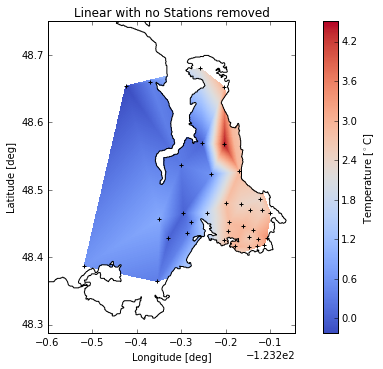

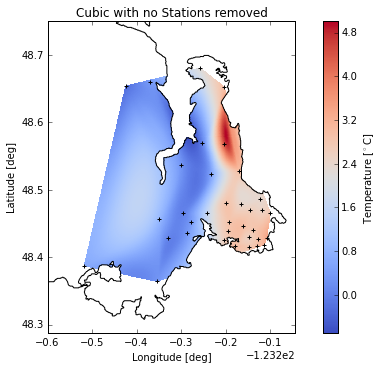

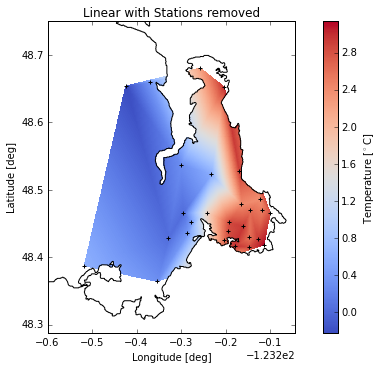

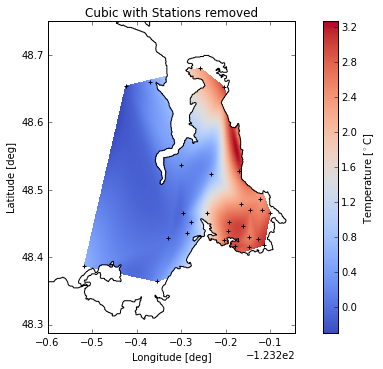

In [14]:
plot2D(lng, lat, cstlng, cstlat, gridx, gridy, zl, mask)
plt.title('Linear with no Stations removed')
plt.show()
plot2D(lng, lat, cstlng, cstlat, gridx, gridy, zc, mask)
plt.title('Cubic with no Stations removed')
plt.show()

plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, zl2, mask)
plt.title('Linear with Stations removed')
plt.show()
plot2D(lng2, lat2, cstlng, cstlat, gridx, gridy, zc2, mask)
plt.title('Cubic with Stations removed')
plt.show()

#EOF

In [289]:
temp = np.zeros_like(data3)
for i in range(np.shape(data3)[1]):
    temp[:,i] = data3[:,i] - np.mean(data3[:,i])
np.shape(temp)

C = np.cov(temp)
Cp,E=np.linalg.eig(C)
for i in range(np.shape(E)[1] ):
    ii = np.argmax(np.abs(E[:,i]))
    E[:,i]=E[:,i]/E[ii,i]
E = E/np.max(np.abs(E),axis=0)
yme = np.dot(np.linalg.inv(E), temp) 
#fig.savefig('EOF.png', bbox_inches='tight')

In [273]:
print temp.size
print data3.size
print datatem.size
print temp[0,0:,].size
print data[:,0].size

735756
735756
735756
26277
35


In [297]:
print np.sum(Cp)
popo = Cp/np.sum(Cp)
print popo
polo = np.sum(popo)
print polo

38.3224538601
[  4.48926618e-01   1.09183539e-01   7.06780857e-02   6.45000805e-02
   5.25856147e-02   4.04954643e-02   3.46763562e-02   2.54079446e-02
   2.21881198e-02   1.91853170e-02   1.81080440e-02   1.47071539e-02
   1.33750169e-02   1.12620792e-02   2.43878421e-17   8.49984721e-03
   7.83320224e-03   1.38837761e-03   5.73082943e-03   2.07687851e-03
   2.33859277e-03   2.62591562e-03   2.96121190e-03   3.34553457e-03
   3.68441039e-03   5.08519948e-03   4.46651658e-03   4.68404976e-03]
1.0


<function matplotlib.pyplot.show>

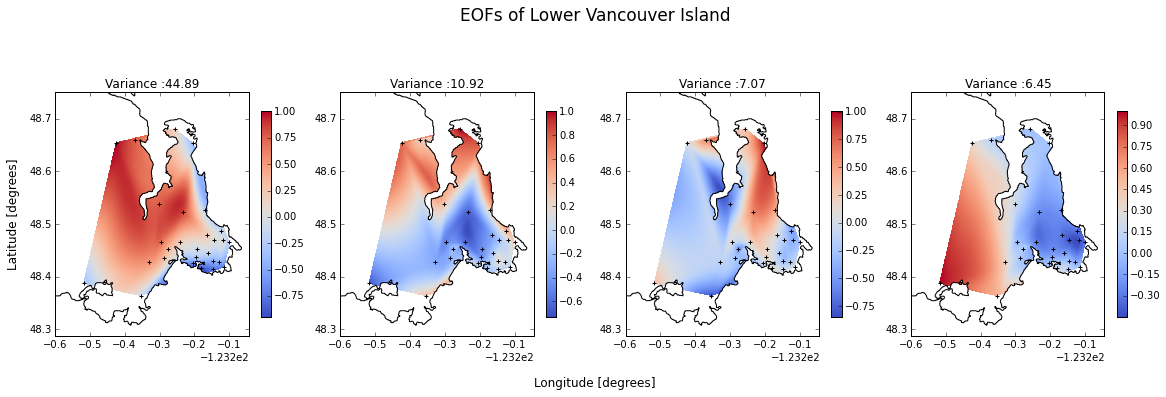

In [420]:
fig, axs = plt.subplots(1,4,figsize=(16,6))#, sharey =True)

for i in range(4):
    zi = interpolate.griddata(np.vstack((lng2,lat2)).T, E[:,i], (gridx,gridy), method='cubic')
    #print Cp[i]/np.sum(Cp)*100.

    #mode_plot(hours, modes, Cp, start=0, end=-1, m=m)
    axs[i].plot(cstlng, cstlat, '-', color='k')
    gridx = gridx*mask
    gridy = gridy*mask
    pcm = axs[i].pcolormesh(gridx, gridy, np.ma.masked_invalid(zi), cmap='coolwarm')
    axs[i].scatter(lng2, lat2, marker='+', color='k')
            #axs[i,j].set_xlabel(r'Longitude [deg]') 
            #axs[i,j].set_ylabel(r'Latitude [deg]')
    axs[i].set_title('Variance :%1.2f'%(Cp[i]/np.sum(Cp) *100))
    axs[i].set_xlim(np.min(cstlng)+0.2, np.max(cstlng)+0.02)
    axs[i].set_ylim(np.min(cstlat)-0.02, 48.75)
    axs[i].set_aspect(1/np.cos(48.6*np.pi/180.))
    plt.colorbar(pcm,ax=axs[i],shrink=0.5)
    plt.tight_layout()

fig.subplots_adjust(hspace=0.11)
#fig.subplots_adjust(wspace=0)
#fig.tight_layout()
#fig.tight_layout(rect=(0.15,0,1,1))
fig.text(0.5, 0.1, r'Longitude [degrees]', ha='center',fontsize=12)
fig.text(-0.01, 0.5, r'Latitude [degrees]', va='center', rotation='vertical',fontsize=12)
#plt.setp([a.get_xticklabels() for a in fig.axes[0:]], visible=False)
plt.suptitle('EOFs of Lower Vancouver Island',fontsize=17)
plt.tight_layout()

#plt.savefig('EOF_mode.png'.format(m))
plt.show

In [398]:
journey = np.arange(len(temp.T))
avg = np.zeros(len(journey))
print journey.size
yme = np.dot(np.linalg.inv(E),data3)
tot = np.zeros((26227,28))
print yme[:,0].size
print yme[0].size

26277
28
26277


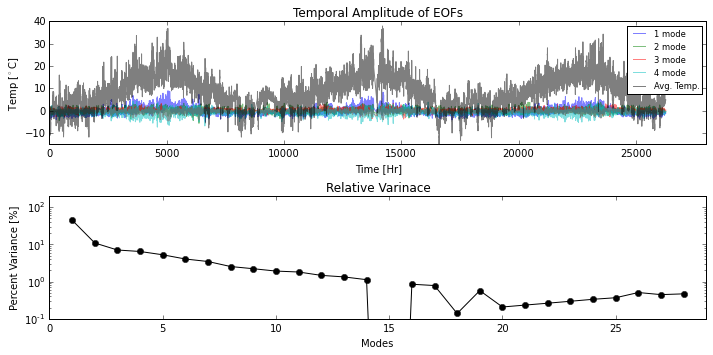

In [419]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
for m in range(4):
    ax[0].plot(journey,yme[m],label='%d mode'%(m+1),alpha=0.5)


    
for i in range(len(journey)):
    avg[i] = np.sum(yme[:,i])


#ax[0].plot(journey,avg,color='m',alpha=0.5, label='Avg. Temp.')
ax[0].plot(journey,avg,color='k',alpha=0.5, label='Avg. Temp.')
ax[0].legend(loc='best',fontsize='small')
ax[0].set_ylim(-15,40)
ax[0].set_xlim(0,28000)
ax[0].set_ylabel(r'Temp [$^{\circ}$C]')
ax[0].set_xlabel('Time [Hr]')
ax[0].set_title('Temporal Amplitude of EOFs')
modes=np.arange(len(Cp))+1

#L = Cp[0]/np.sum(Cp)
#holy = L*avg - yme[0]
#ax[1].plot(journey, holy)
ax[1].semilogy(modes,(Cp/np.sum(Cp))*100.,color='k')
ax[1].semilogy(modes,(Cp/np.sum(Cp))*100.,'o',color='k',label='Relative Varinace')

ax[1].set_xlabel('Modes')
ax[1].set_ylabel(r'Percent Variance [%]')
ax[1].set_title('Relative Varinace')
ax[1].set_xlim(0,29)
ax[1].set_ylim(1e-1,2e2)


plt.tight_layout()
#plt.savefig('Ampltiudes.png'.format(m))
plt.show()


#Minute Data

In [18]:
# fill in nan values with linear interpolation

def interp(data, rmean=False):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    if rmean:
        data -= np.mean(data)  # remove mean
    return data

dc = interp(dc, rmean=False)
jb = interp(jb, rmean=False)
jm = interp(jm, rmean=False)
uv = interp(uv, rmean=False)

mindata = np.array([dc,jb,jm,uv])
minname = ['Deep Cove', 'James Bay', 'John Muir', 'Uvic']
color = ['#092eb2', '#b3afcc','#8dcc78','#cc1d1f']

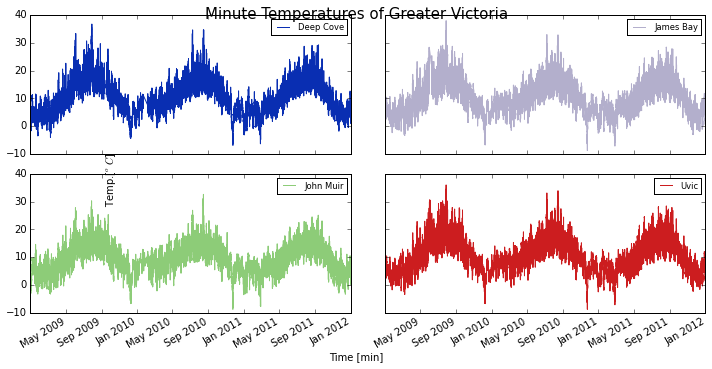

In [19]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,5))        
ldc = ax[0,0].plot_date(mins, dc, color[0], label=minname[0]) ; ax[0,0].legend(loc='best', fontsize='small')
ljb = ax[0,1].plot_date(mins, jb, color[1], label=minname[1]) ; ax[0,1].legend(loc='best', fontsize='small')
ljm = ax[1,0].plot_date(mins, jm, color[2], label=minname[2]) ; ax[1,0].legend(loc='best', fontsize='small')
luv = ax[1,1].plot_date(mins, uv, color[3], label=minname[3]) ; ax[1,1].legend(loc='best', fontsize='small')


# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
#print fig.axes[:-1]
plt.setp([a.get_xticklabels() for a in fig.axes[:1]], visible=False)

fig.text(0.5, 0.0, 'Time [min]', ha='center',fontsize=10)
fig.text(0.15, 0.5, r'Temp.[$^oC$]', va='center', rotation='vertical',fontsize=10)
plt.suptitle('Minute Temperatures of Greater Victoria',fontsize=15)

fig.tight_layout(rect=(0.15,0.01,0.9,0.9))

fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig('figures/min_timeseries.png')

High-pass filter lets high-frequency (detailed/local information) pass.

Low-pass filter lets low-frequency (coarse/rough/global information) pass.

Thus a low-pass filter is used for the four minute datas since they relay global infromation and to look for yearly patterns and fluxuations rather than daily fluxuations

#Low pass filter
optimization method to find the right amount of days

In [20]:
# ts is minutes in a day, stopband is how many days you want to filter together, also used to optimize the number of days
def lowpass(data, stopband,ts = 60.*24):
    mean = np.mean(data); std = np.std(data)
    value = 0; newmean = 0.; newstd = 0.
    fdata = np.zeros((len(data),len(stopband)))
    for ind in range(len(stopband)):
        df = 1./(stopband[ind]*ts)
        wp = 0.7*df
        ws = 0.9*df
        n, fn = signal.ellipord(wp, ws, 0.5, 20.)
        b, a = signal.ellip(n, 0.5, 20., fn)
        fdata[0:,ind] = signal.lfilter(b, a, data)
        if ind == 0:
            newmean = np.mean(fdata[0:,ind])
            newstd = np.mean(fdata[0:,ind])
        elif ind > 0:
            up = np.abs(np.mean(fdata[0:,ind]) - mean)
            down = np.abs(newmean - mean)
            if up < down:
                value = ind
                newmean = np.mean(fdata[0:,ind])
            elif up == down:
                sup = np.abs(np.std(fdata[0:,ind]) - std)
                sdown = np.abs(newstd - std)
                if sup < down:
                    value = ind
                    newstd = np.std(fdata[0:,ind])
        
    #f = signal.filtfilt(b,a,dc)
    return fdata[0:,value], value

In [21]:
stopband = np.arange(2.,6.,0.1)

fdc, value = lowpass(dc, stopband)

fjb, value = lowpass(jb, stopband)

fjm, value = lowpass(jm, stopband)

fuv, value = lowpass(uv, stopband)

In [22]:
print "DC"
print np.mean(dc),np.std(dc)#np.mean(fdc), stopband[value], np.std(dc),np.std(fdc)

print "JB"
print np.mean(jb),np.std(jb)#np.mean(fjb), stopband[value], np.std(jb),np.std(fjb)

print "JM"
print np.mean(jm),np.std(jm)#np.mean(fjm), stopband[value], np.std(jm),np.std(fjm)

print "UV"
print np.mean(uv),np.std(uv)#np.mean(fuv), stopband[value], np.std(uv),np.std(fuv)

print 'Average'
print np.mean([np.mean(jb),np.mean(dc),np.mean(jm), np.mean(uv)]), np.mean([np.std(jb),np.std(dc),np.std(jm), np.std(uv)])

DC
10.3016300448 5.98099047791
JB
10.3107251853 5.83675368414
JM
9.11998334356 4.8364971532
UV
10.2371553568 5.70055093019
Average
9.9923734826 5.58869806136


In [23]:
color2 = ['#92ff19','#005fff','#7540ff','#c7ff40'] 
minname2 = ['Filtered','Filtered', 'Filtered', 'Filtered']
filt = np.array([fdc,fjb,fjm,fuv])

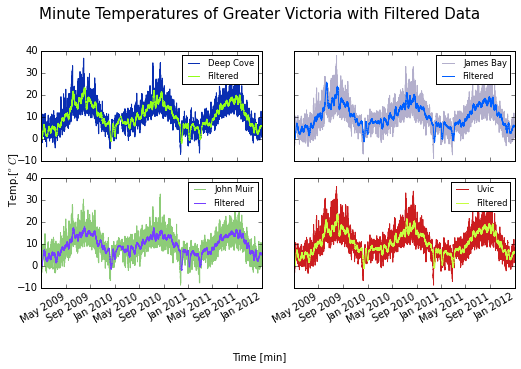

In [58]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10,5))  

ldc = ax[0,0].plot_date(mins, dc, color[0], label=minname[0]) 
lfdc = ax[0,0].plot_date(mins, filt[0], color2[0], label=minname2[0])
ax[0,0].legend(loc='upper right', fontsize='small')
ljb = ax[0,1].plot_date(mins, jb, color[1], label=minname[1]) 
lfjb = ax[0,1].plot_date(mins, filt[1], color2[1], label=minname2[1]) 
ax[0,1].legend(loc='upper right', fontsize='small')
ljm = ax[1,0].plot_date(mins, jm, color[2], label=minname[2]) 
lfjm = ax[1,0].plot_date(mins, filt[2], color2[2], label=minname2[2]) 
ax[1,0].legend(loc='upper right', fontsize='small')
luv = ax[1,1].plot_date(mins, uv, color[3], label=minname[3]) 
lfuv = ax[1,1].plot_date(mins, filt[3], color2[3], label=minname2[3]) 
ax[1,1].legend(loc='upper right', fontsize='small')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:1]], visible=False)

fig.text(0.5, 0.0, 'Time [min]', ha='center',fontsize=10)
fig.text(0.15, 0.5, r'Temp.[$^oC$]', va='center', rotation='vertical',fontsize=10)
plt.suptitle('Minute Temperatures of Greater Victoria with Filtered Data',fontsize=15)

fig.tight_layout(rect=(0.15,0.01,0.9,0.9))

fig.autofmt_xdate()
#plt.tight_layout()
#fig.savefig('minute.png', bbox_inches='tight')

#Histogram

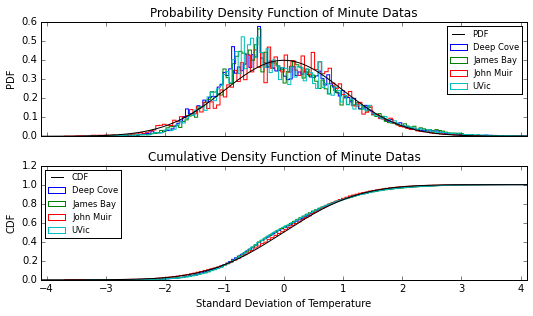

In [34]:
def mean_std(data):
    return (data - np.mean(data))/np.std(data)


bins=150

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize = (10,5))
ax1.hist(mean_std(dc), bins, normed=True, histtype='step', label='Deep Cove')
ax1.hist(mean_std(jb), bins, normed=True, histtype='step', label='James Bay')
ax1.hist(mean_std(jm), bins, normed=True, histtype='step', label='John Muir')
ax1.hist(mean_std(uv), bins, normed=True, histtype='step', label='UVic')
x = np.linspace(-5,5,1000)
ax1.set_xlim(-4.1,4.1)
ax1.plot(x,mlab.normpdf(x,0,1),'k',label='PDF')

ax1.legend(loc='best',fontsize='small')
#ax.set_xlabel('Standard Deviation of Temperature')
ax1.set_ylabel('PDF')
ax1.set_title('Probability Density Function of Minute Datas')

ax2.hist(mean_std(dc), bins, normed=True, cumulative=True, histtype='step', label='Deep Cove')
ax2.hist(mean_std(jb), bins, normed=True, cumulative=True, histtype='step', label='James Bay')
ax2.hist(mean_std(jm), bins, normed=True, cumulative=True, histtype='step', label='John Muir')
ax2.hist(mean_std(uv), bins, normed=True, cumulative=True, histtype='step', label='UVic')
#x = np.linspace(-5,5,1000)
ax2.plot(x,stats.norm.cdf(x,0,1),'k',label='CDF')
ax2.set_xlim(-4.1,4.1)
ax2.legend(loc='best',fontsize='small')
ax2.set_xlabel('Standard Deviation of Temperature')
ax2.set_ylabel('CDF')
ax2.set_title('Cumulative Density Function of Minute Datas')

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

fig.tight_layout(rect=(0.15,0.01,0.9,0.9))
plt.show()
#fig.savefig('prob.png', bbox_inches='tight')


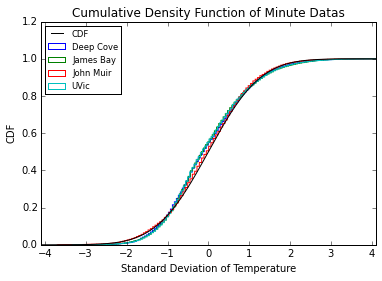

In [26]:
bins=150

fig, ax = plt.subplots(1,1)
ax.hist(mean_std(dc), bins, normed=True, cumulative=True, histtype='step', label='Deep Cove')
ax.hist(mean_std(jb), bins, normed=True, cumulative=True, histtype='step', label='James Bay')
ax.hist(mean_std(jm), bins, normed=True, cumulative=True, histtype='step', label='John Muir')
ax.hist(mean_std(uv), bins, normed=True, cumulative=True, histtype='step', label='UVic')
x = np.linspace(-5,5,1000)
ax.plot(x,stats.norm.cdf(x,0,1),'k',label='CDF')
ax.set_xlim(-4.1,4.1)
ax.legend(loc='best',fontsize='small')
ax.set_xlabel('Standard Deviation of Temperature')
ax.set_ylabel('CDF')
ax.set_title('Cumulative Density Function of Minute Datas')
plt.show()

#Power Spectra

In [27]:
Nfft = 2048*12
dt = 60.
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

Pdc, f = mlab.psd(dc, **args)
Pjb, f = mlab.psd(jb, **args)
Pjm, f = mlab.psd(jm, **args)
Puv, f = mlab.psd(uv, **args)

Pdcjb, ff = mlab.csd(dc, jb, **args)
Pjmuv, ff = mlab.csd(jm, uv, **args)
Pdcjm, ff = mlab.csd(dc, jm, **args)
Pdcuv, ff = mlab.csd(dc, uv, **args)
Pjbjm, ff = mlab.csd(jb, jm, **args)
Pjbuv, ff = mlab.csd(jb, uv, **args)

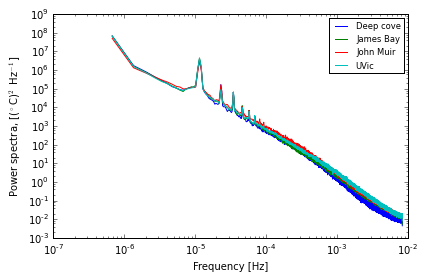

In [28]:
yr = 3600.*24.*365.
day = 3600.*24.
h12 = 3600.*24./2.
h8 = 3600.*24./3.
h6 = 3600.*24./4.

#plt.axvline(1./day, color='k', ls=':')
plt.loglog(f, np.abs(Pdc), label='Deep cove')#, alpha=0.5)
plt.loglog(f, np.abs(Pjb), label='James Bay')#, alpha=0.5)
plt.loglog(f, np.abs(Pjm), label='John Muir')#, alpha=0.5)
plt.loglog(f, np.abs(Puv), label='UVic')#, alpha=0.5)
plt.xlabel('Frequency [Hz]') ; plt.ylabel('Power spectra, [($^\circ$C)$^2$ Hz$^{-1}$]')
plt.legend(loc='best', fontsize='small')

plt.tight_layout()

#Cross Spectral

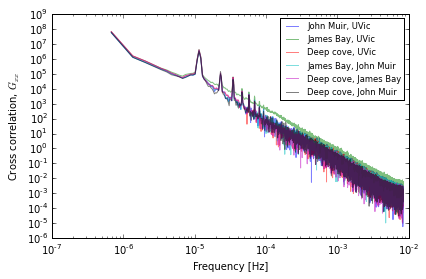

In [29]:
plt.loglog(f, np.abs(Pjmuv), label='John Muir, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjbuv), label='James Bay, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pdcuv), label='Deep cove, UVic', alpha=0.5)
plt.loglog(f, np.abs(Pjbjm), label='James Bay, John Muir', alpha=0.5)
plt.loglog(f, np.abs(Pdcjb), label='Deep cove, James Bay', alpha=0.5)
plt.loglog(f, np.abs(Pdcjm), '-k', label='Deep cove, John Muir', alpha=0.5)


plt.xlabel('Frequency [Hz]') ; plt.ylabel('Cross correlation, $G_{xx}$')
plt.legend(loc='best', fontsize='small')

plt.tight_layout()

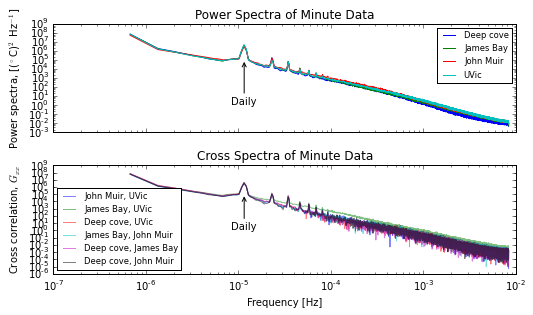

In [69]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize = (10,5))
ax1.loglog(f, np.abs(Pdc), label='Deep cove')#, alpha=0.5)
ax1.loglog(f, np.abs(Pjb), label='James Bay')#, alpha=0.5)
ax1.loglog(f, np.abs(Pjm), label='John Muir')#, alpha=0.5)
ax1.loglog(f, np.abs(Puv), label='UVic')#, alpha=0.5)

ax1.set_ylabel('Power spectra, [($^\circ$C)$^2$ Hz$^{-1}$]')
ax1.legend(loc='best',fontsize='small')
ax1.set_title('Power Spectra of Minute Data')

ax2.loglog(f, np.abs(Pjmuv), label='John Muir, UVic', alpha=0.5)
ax2.loglog(f, np.abs(Pjbuv), label='James Bay, UVic', alpha=0.5)
ax2.loglog(f, np.abs(Pdcuv), label='Deep cove, UVic', alpha=0.5)
ax2.loglog(f, np.abs(Pjbjm), label='James Bay, John Muir', alpha=0.5)
ax2.loglog(f, np.abs(Pdcjb), label='Deep cove, James Bay', alpha=0.5)
ax2.loglog(f, np.abs(Pdcjm), '-k', label='Deep cove, John Muir', alpha=0.5)

#ax2.annotate('Daily', xy=(1./day, 1.e5),  xycoords='data', xytext=(1./day, 1.e-2), textcoords='data', 
#            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))

ax2.annotate('Daily', xy=(1./3600/24, 1.e5),  xycoords='data',
                xytext=(1./3600/24, 1), textcoords='data',
                horizontalalignment='center',
                arrowprops=dict(arrowstyle="->")
                )

ax1.annotate('Daily', xy=(1./3600./24, 1.e5),  xycoords='data',
                xytext=(1./3600./24, 1), textcoords='data',
                horizontalalignment='center',
                arrowprops=dict(arrowstyle="->")
                )

ax2.legend(loc='best',fontsize='small')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Cross correlation, $G_{xx}$')
ax2.set_title('Cross Spectra of Minute Data')

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

fig.tight_layout(rect=(0.15,0.01,0.9,0.9))
plt.show()

fig.savefig('spectra.png', bbox_inches='tight')

# Coherence Squared, Phase

In [31]:
cohjmuv = abs(Pjmuv)**2/Pjm/Puv
cohjbuv = abs(Pjbuv)**2/Pjb/Puv
cohdcuv = abs(Pdcuv)**2/Pdc/Puv
cohjbjm = abs(Pjbjm)**2/Pjb/Pjm
cohdcjb = abs(Pdcjb)**2/Pdc/Pjb
cohdcjm = abs(Pdcjm)**2/Pdc/Pjm

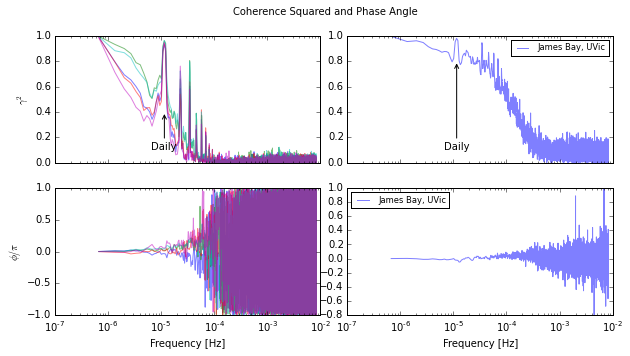

In [68]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows=2, figsize = (10,5))#, sharex=True)
ax1.semilogx(f,cohjmuv, label='John Muir, UVic', alpha=0.5)
#ax1.semilogx(f,cohjbuv, label='James Bay, UVic', alpha=0.5)
ax1.semilogx(f,cohdcuv, label='Deep Cove, UVic', alpha=0.5)
ax1.semilogx(f,cohjbjm, label='James Bay, John Muir', alpha=0.5)
ax1.semilogx(f,cohdcjb, label='Deep Cove, James Bay', alpha=0.5)
ax1.semilogx(f,cohdcjm, label='Deep Cove, John Muir', alpha=0.5)

fig.suptitle('Coherence Squared and Phase Angle')
ax1.set_ylabel(r'$\gamma^2$')
#ax1.legend(loc='upper right', fontsize='small')

ax3.semilogx(f,np.angle(Pjmuv)/np.pi, label='John Muir, UVic', alpha=0.5)
#ax3.semilogx(f,np.angle(Pjbuv)/np.pi, label='James Bay, UVic', alpha=0.5)
ax3.semilogx(f,np.angle(Pdcuv)/np.pi, label='Deep Cove, UVic', alpha=0.5)
ax3.semilogx(f,np.angle(Pjbjm)/np.pi, label='James Bay, John Muir', alpha=0.5)
ax3.semilogx(f,np.angle(Pdcjb)/np.pi, label='Deep Cove, James Bay', alpha=0.5)
ax3.semilogx(f,np.angle(Pdcjm)/np.pi, label='Deep Cove, John Muir', alpha=0.5)

ax3.set_xlabel('Frequency [Hz]') ; ax3.set_ylabel('$\phi / \pi$')
#ax3.legend(loc='best', fontsize='small')

ax2.semilogx(f,cohjbuv, label='James Bay, UVic', alpha=0.5)
ax2.legend(loc='best', fontsize='small')

ax4.semilogx(f,np.angle(Pjbuv)/np.pi, label='James Bay, UVic', alpha=0.5)
ax4.set_xlabel('Frequency [Hz]')
ax4.legend(loc='best', fontsize='small')

ax1.annotate('Daily', xy=(1./3600/24, 0.4),  xycoords='data',
                xytext=(1./3600/24, 0.1), textcoords='data',
                horizontalalignment='center',
                arrowprops=dict(arrowstyle="->")
                )

ax2.annotate('Daily', xy=(1./3600./24, 0.8),  xycoords='data',
                xytext=(1./3600./24, 0.1), textcoords='data',
                horizontalalignment='center',
                arrowprops=dict(arrowstyle="->")
                )

#fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0.1)
plt.setp([a.get_xticklabels() for a in fig.axes[:2]], visible=False)
plt.show()
#fig.tight_layout(rect=(0.20,0.01,0.9,0.9))
fig.savefig('Coherence.png', bbox_inches='tight')
#plt.tight_layout()